# Homework 5

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Задача №1 - Можете ли вы отличить сорняки от рассады?

Теперь приступим к задаче классификации на картинках. Реализуйте программу, которая определяет тип рассады на изображении. 

Для того, чтобы определить характерные особенности каждого типа рассады, у вас есть train. Train это папка, в которой картинки уже классифицированы и лежат в соответствующих папках. Исходя из этой информации можете найти признаки, присущие конкретному растению.

Проверка вашего решения будет на происходить на test. В папке test уже нет метки класса для каждой картинки. 

[Ссылка на Яндекс-диск](https://yadi.sk/d/0Zzp0klXT0iRmA), все картинки тут.

Примеры изображений для теста:
<table><tr>
    <td> <img src="https://i.ibb.co/tbqR37m/fhj.png" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/6yL3Wmt/sfg.png" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/pvn7NvF/asd.png" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [2]:
def transform(image):
    im = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    h_im = im[:,:,0]
    h1 = h_im < 30
    h2 = h_im > 90
    
    v = im[:,:,2] > 150
    s = im[:,:,1] < 100
    im[:,:][h1 | h2 | v | s] = [0, 0, 0]
    
#     im[:,:][h1 | h2] = [0, 0, 0]
    return cv2.cvtColor(im, cv2.COLOR_HSV2RGB)

In [3]:
# def spec_points(image):
#     im = transform(image)
#     hyp_params = dict(
#         nfeatures = 150,
#         nOctaveLayers = 10,
#         contrastThreshold = 0.05,
#         edgeThreshold = 6,
#         sigma = 4.0)  # hyp params
#     detector = cv2.xfeatures2d.SIFT_create(**hyp_params)

#     _, desc = detector.detectAndCompute(im, None)
#     try:
#         return desc.astype(np.float32)
#     except:
#         return None

In [4]:
def spec_points(image):
    im = transform(image)
    hyp_params = dict(
        nfeatures = 150,
        nOctaveLayers = 10,
        contrastThreshold = 0.05,
        edgeThreshold = 6,
        sigma = 4.0)  # hyp params
    detector = cv2.xfeatures2d.SIFT_create(**hyp_params)

    _, desc = detector.detectAndCompute(im, None)
    try:
        return desc.astype(np.float32)
    except:
        return None

In [147]:
def identification(old_train, test, names):
    ratio_thresh = 0.75
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    descs = []
    for i in range(len(train)):
        descs.append([])
        for im in train[i]:
            descs[-1].append(spec_points(im))
            
    inds_res = []
    for im in test:

        test_desc = spec_points(im)

        max_num = 0
        ind_res = 0
        for ind, descsi in enumerate(descs):
            m_num = 0
            for desc in descsi:
                matches = flann.knnMatch(test_desc, desc, k=2)
                num = 0
                for m, n in matches:
                    if m.distance < ratio_thresh * n.distance:
                        num += 1

                            
                if m_num < num:
                    m_num = num
                    
                
            if m_num > max_num:
                max_num = m_num
                ind_res = ind
        inds_res.append(ind_res)
    return inds_res

In [ ]:
n = 40
inds_res = identification(train, test[:n], names)
print(inds_res)
print(res[:n])
err = 0
for i in range(len(inds_res)):
    if inds_res[i] != res[i]:
        err += 1
print(err)

In [137]:
err = 0
for i in range(len(inds_res)):
    if inds_res[i] != res[i]:
        err += 1
        print(f"ind {i}: my - {inds_res[i]}, real - {res[i]}")
print(err)

ind 9: my - 1, real - 0
ind 10: my - 0, real - 1
ind 36: my - 1, real - 3
3


In [157]:
def get_test():
    path = "./plants/test/"
    test = []
    for path_im in os.listdir(path):
        test.append(cv2.imread(path+path_im))
        test[-1] = cv2.cvtColor(test[-1], cv2.COLOR_BGR2RGB)
    return test

In [158]:
def get_train():
    path = "./plants/train/"
    names = os.listdir(path)
    train = []
    for name in names:
        train.append([])
        for path_im in os.listdir(path+name):
            train[-1].append(cv2.imread(path+name+'/'+path_im))
            train[-1][-1] = cv2.cvtColor(train[-1], cv2.COLOR_BGR2RGB)
    return names, train

In [8]:
names, train = get_train()
test = get_test()

In [9]:
max_len = 0
for i in range(len(train)):
    max_len = len(train[i]) if len(train[i]) > max_len else max_len

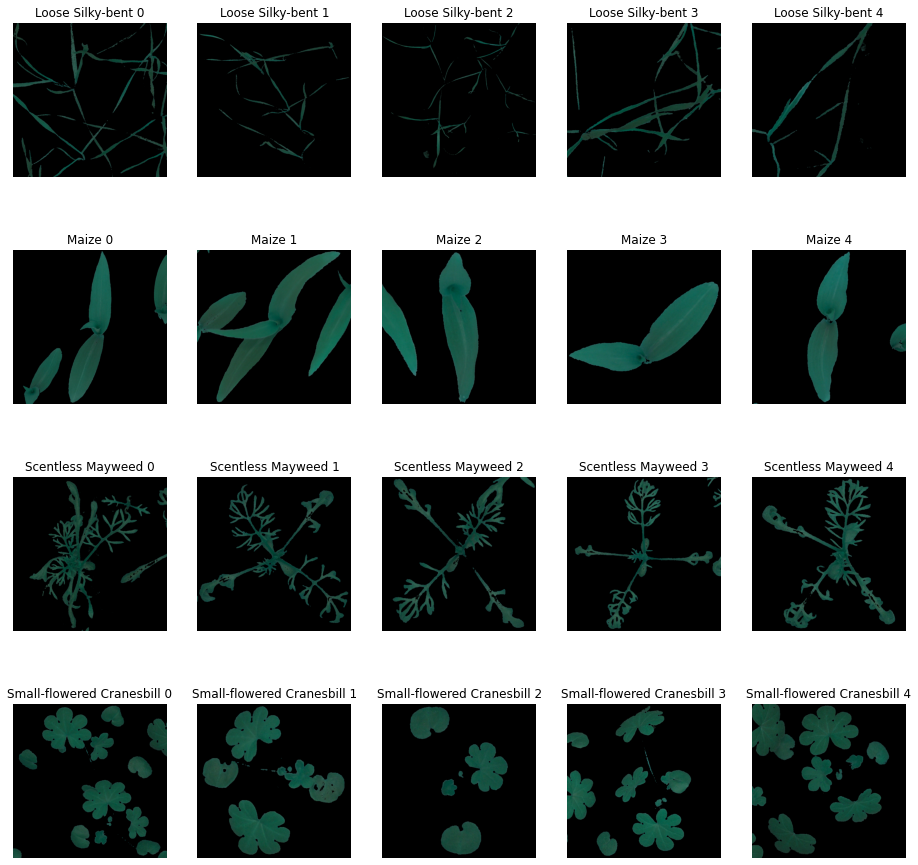

In [10]:
fig, axes = plt.subplots(len(train), max_len, figsize=(16, 16))

for i in range(len(train)):
    for j in range(len(train[i])):
        axes[i][j].imshow(transform(train[i][j]))
        axes[i][j].set_title(f'{names[i]} {j}')
        axes[i][j].axis('off')

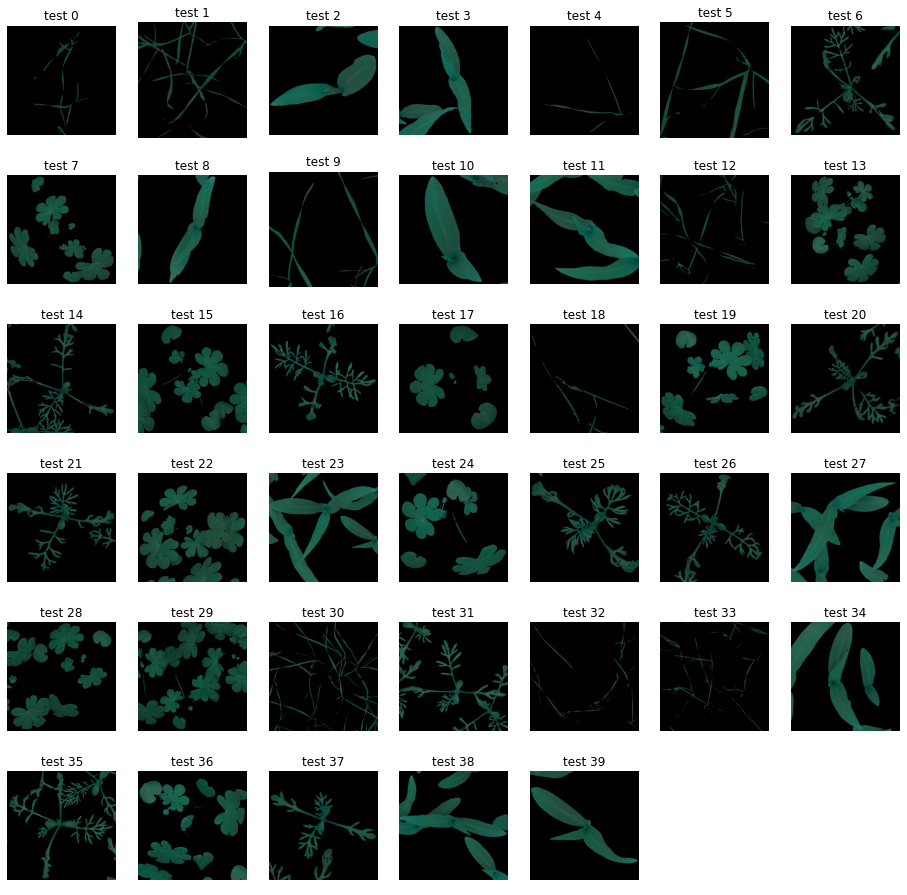

In [11]:
a = int(np.sqrt(len(test)))
fig, axes = plt.subplots(a, len(test)//a+1, figsize=(16, 16))
axes = axes.ravel()

for i in range(len(test)):
    axes[i].imshow(transform(test[i]))
    axes[i].set_title(f'test {i}')
    
for ax in axes:
    ax.axis('off')

In [12]:
res = [0, 0, 1, 1, 0, 0, 2, 3, 1, 0, 1, 1, 0, 3, 2, 3, 2, 3, 0, 3, 2, 2, \
       3, 1, 3, 2, 2, 1, 3, 3, 0, 2, 0, 0, 1, 2, 3, 2, 1, 1]
len(res)

40

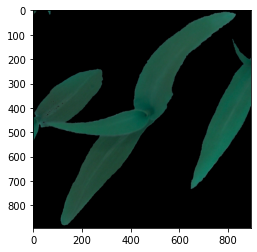

In [13]:
im = transform(train[1][1])
plt.imshow(im)

# Задача №2 - Собери пазл (2.0).

Даны кусочки изображения, ваша задача склеить пазл в исходную картинку. 

Условия:
* Дано исходное изображение для проверки, использовать собранное изображение в самом алгоритме нельзя;
* Картинки имеют друг с другом пересечение;
* После разрезки кусочки пазлов не были повернуты или отражены;
* НЕЛЬЗЯ выбрать опорную картинку для сбора пазла, как это было в homework 3
* В процессе проверки решения пазлы могут быть перемешаны, т.е. порядок пазлов в проверке может отличаться от исходного 

Изображения расположены по [ссылке](https://disk.yandex.ru/d/XtpawH1sV9UDlg).

Примеры изображений:
<img src="puzzle/su_fighter.jpg" alt="Drawing" style="width: 300px;"/>
<table><tr>
    <td> <img src="puzzle/su_fighter_shuffle/0.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/1.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/2.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/3.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [54]:
# вспомогательная функция
def plot_one_image(src_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение.
    
    :param src_image: np.ndarray: исходное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 1, figsize=(16, 16), constrained_layout=False)
    ax1 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.axis('off')
    plt.show()

In [102]:
# def spec_points2(image):
#     im = image.copy()
#     hyp_params = dict(
#         nfeatures = 150,
#         nOctaveLayers = 8,
#         contrastThreshold = 0.01,
#         edgeThreshold = 10,
#         sigma = 4.0)  # hyp params
#     detector = cv2.xfeatures2d.SIFT_create(**hyp_params)

#     keypoints, desc = detector.detectAndCompute(im, None)
#     try:
#         return keypoints, desc.astype(np.float32)
#     except:
#         return None, None

In [589]:
def spec_points2(image):
    im = image.copy()
    hyp_params = dict(
        nfeatures = 50,
        nOctaveLayers = 6,
        contrastThreshold = 0.06,
        edgeThreshold = 20,
        sigma = 3)  # hyp params
    detector = cv2.xfeatures2d.SIFT_create(**hyp_params)

    keypoints, desc = detector.detectAndCompute(im, None)
    
    try:
        if len(desc) < 10:
            hyp_params = dict(
                nfeatures = 50,
                nOctaveLayers = 8,
                contrastThreshold = 0.007,
                edgeThreshold = 20,
                sigma = 2.6)

            detector = cv2.xfeatures2d.SIFT_create(**hyp_params)
            keypoints, desc = detector.detectAndCompute(im, None)
    except:
        hyp_params = dict(
                nfeatures = 50,
                nOctaveLayers = 8,
                contrastThreshold = 0.007,
                edgeThreshold = 20,
                sigma = 2.6)
        
        detector = cv2.xfeatures2d.SIFT_create(**hyp_params)
        keypoints, desc = detector.detectAndCompute(im, None)
        
    try:
        return keypoints, desc.astype(np.float32)
    except:
        return [], []

In [590]:
def draw_res_matches(pieces, keypoints, good_matches):
    img_res = 0

    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
                      )
   
    for i in range(len(good_matches)):
        for j, gd_matches in good_matches[i]:
            img_matches = np.empty((max(pieces[i].shape[0], pieces[j].shape[0]), \
                                    pieces[i].shape[1] + pieces[j].shape[1], 3), dtype=np.uint8)
        
            cv2.drawMatches(pieces[i], keypoints[i], pieces[j], keypoints[j], gd_matches, img_matches, **draw_params)
            if type(img_res) == type(img_matches):
                img_res = np.r_[img_res, img_matches]
            else:
                img_res = img_matches
            
        
    plot_one_image(img_res)

In [591]:
def pos_i_piece(pos_pieces, i):
    if not(i in [l[0] for l in pos_pieces]):
        return None
    
    return pos_pieces[([l[0] for l in pos_pieces]).index(i)][1]

In [596]:
def draw_res(pieces, keypoints, good_matches):
    hsv_pieces = [cv2.cvtColor(piece, cv2.COLOR_RGB2HSV) for piece in pieces]
    
    pos_pieces = [(0, [0, 0])]
    num = 0
    while num < len(pos_pieces):     
        i = pos_pieces[num][0]
        for j, gd_matches in good_matches[i]:
            if pos_i_piece(pos_pieces, j) != None:
                continue
            if not len(gd_matches):
                continue
            
            dx = np.zeros([len(gd_matches), 1])
            dy = np.zeros([len(gd_matches), 1])
            skip = [False]*len(gd_matches)
            for k, gd_matche in enumerate(gd_matches):
                x1, y1 = keypoints[i][gd_matche.queryIdx].pt
                x2, y2 = keypoints[j][gd_matche.trainIdx].pt
                int_x1, int_y1, int_x2, int_y2 = list(map(int, np.round(np.array([x1, y1, x2, y2]))))

                if np.min(np.abs(hsv_pieces[i][int_y1-3:int_y1+4,int_x1-3:int_x1+4, 0] - \
                                     hsv_pieces[j][int_y2][int_x2][0])) > 5:
                    skip[k] = True
                    continue

                if np.min(np.abs(hsv_pieces[i][int_y1-3:int_y1+4,int_x1-3:int_x1+4, 1] - \
                                     hsv_pieces[j][int_y2][int_x2][1])) > 50:
                    skip[k] = True
                    continue

                if np.min(np.abs(hsv_pieces[i][int_y1-3:int_y1+4,int_x1-3:int_x1+4, 2] - \
                                    hsv_pieces[j][int_y2][int_x2][2])) > 50:
                    skip[k] = True
                    continue
                
                dx[k] = x1 - x2
                dy[k] = y1 - y2
                
            if all(skip):
                continue
            
            skip = list(map(lambda x:not x, skip))
            dx = dx[skip]
            dy = dy[skip]
#             if len(dy) < 2:
#                 continue
            
            av_dx = dx.mean()
            av_dy = dy.mean()
            
            ind_y = np.argmin(np.abs(dy-av_dy))
            ind_x = np.argmin(np.abs(dx-av_dx))

#             y = int(np.round(dy[np.argmin(np.abs(dy-av_dy))]))
#             x = int(np.round(dx[np.argmin(np.abs(dx-av_dx))]))
            y = int(np.round(dy[ind_y]))
            x = int(np.round(dx[ind_x]))
            
#             dy = dy - dy[ind_y]
#             dy[ind_y] = dy.max()
#             if abs(dy.min()) < 0.1:
#                 continue
            
#             dx = dx - dx[ind_x]
#             dx[ind_x] = dx.max()
#             if abs(dx.min()) < 0.1:
#                 continue
            
            x0, y0 = pos_i_piece(pos_pieces, i)
            x += x0
            y += y0

            pos_pieces.append((j, [x,y]))
        num += 1

    x_pieces = np.array([l[1][0] for l in pos_pieces])
    y_pieces = np.array([l[1][1] for l in pos_pieces])
    min_x = x_pieces.min()
    max_x = x_pieces.max()
    min_y = y_pieces.min()
    max_y = y_pieces.max()

    sh_piece_max_x = pieces[pos_pieces[np.argmax(x_pieces)][0]].shape
    sh_piece_max_y = pieces[pos_pieces[np.argmax(y_pieces)][0]].shape
    max_x += sh_piece_max_x[1]
    max_y += sh_piece_max_y[0]


    res_im = np.zeros([max_y-min_y, max_x-min_x, 3])
    for i, pos_piece in pos_pieces:
        h, w, _ = pieces[i].shape
        x = pos_piece[0]
        y = pos_piece[1]
        res_im[y - min_y : y - min_y + h, x - min_x : x - min_x + w] = pieces[i]
    print(len(pos_pieces))
    res_im = res_im.astype(np.uint8)
    plot_one_image(res_im)

In [ ]:
# def draw_res(pieces, keypoints, good_matches):
#     hsv_pieces = [cv2.cvtColor(piece, cv2.COLOR_RGB2HSV) for piece in pieces]
    
#     pos_pieces = [(0, [0, 0])]
#     num = 0
#     while num < len(pos_pieces):     
#         i = pos_pieces[num][0]
#         temp = sorted(good_matches[i], key=lambda x: len(x[1]))
#         for j, gd_matches in temp:
#             if pos_i_piece(pos_pieces, j) != None:
#                 continue
#             if not len(gd_matches):
#                 continue

#             dx = np.zeros([len(gd_matches), 1])
#             dy = np.zeros([len(gd_matches), 1])
#             skip = [False]*len(gd_matches)
#             for k, gd_matche in enumerate(gd_matches):
#                 x1, y1 = keypoints[i][gd_matche.queryIdx].pt
#                 x2, y2 = keypoints[j][gd_matche.trainIdx].pt
#                 int_x1, int_y1, int_x2, int_y2 = list(map(int, np.round(np.array([x1, y1, x2, y2]))))

#                 if np.min(np.abs(hsv_pieces[i][int_y1-3:int_y1+4,int_x1-3:int_x1+4, 0] - \
#                                      hsv_pieces[j][int_y2][int_x2][0])) > 5:
#                     skip[k] = True
#                     continue

#                 if np.min(np.abs(hsv_pieces[i][int_y1-3:int_y1+4,int_x1-3:int_x1+4, 1] - \
#                                      hsv_pieces[j][int_y2][int_x2][1])) > 50:
#                     skip[k] = True
#                     continue

#                 if np.min(np.abs(hsv_pieces[i][int_y1-3:int_y1+4,int_x1-3:int_x1+4, 2] - \
#                                     hsv_pieces[j][int_y2][int_x2][2])) > 50:
#                     skip[k] = True
#                     continue
                
#                 dx[k] = x1 - x2
#                 dy[k] = y1 - y2
                
#             if all(skip):
#                 continue
            
#             skip = list(map(lambda x:not x, skip))
#             dx = dx[skip]
#             dy = dy[skip]
# #             if len(dy) < 2:
# #                 continue
            
#             av_dx = dx.mean()
#             av_dy = dy.mean()
            
#             ind_y = np.argmin(np.abs(dy-av_dy))
#             ind_x = np.argmin(np.abs(dx-av_dx))

# #             y = int(np.round(dy[np.argmin(np.abs(dy-av_dy))]))
# #             x = int(np.round(dx[np.argmin(np.abs(dx-av_dx))]))
#             y = int(np.round(dy[ind_y]))
#             x = int(np.round(dx[ind_x]))
            
# #             dy = dy - dy[ind_y]
# #             dy[ind_y] = dy.max()
# #             if abs(dy.min()) < 0.1:
# #                 continue
            
# #             dx = dx - dx[ind_x]
# #             dx[ind_x] = dx.max()
# #             if abs(dx.min()) < 0.1:
# #                 continue
            
#             x0, y0 = pos_i_piece(pos_pieces, i)
#             x += x0
#             y += y0

#             pos_pieces.append((j, [x,y]))
#         num += 1

#     x_pieces = np.array([l[1][0] for l in pos_pieces])
#     y_pieces = np.array([l[1][1] for l in pos_pieces])
#     min_x = x_pieces.min()
#     max_x = x_pieces.max()
#     min_y = y_pieces.min()
#     max_y = y_pieces.max()

#     sh_piece_max_x = pieces[pos_pieces[np.argmax(x_pieces)][0]].shape
#     sh_piece_max_y = pieces[pos_pieces[np.argmax(y_pieces)][0]].shape
#     max_x += sh_piece_max_x[1]
#     max_y += sh_piece_max_y[0]


#     res_im = np.zeros([max_y-min_y, max_x-min_x, 3])
#     for i, pos_piece in pos_pieces:
#         h, w, _ = pieces[i].shape
#         x = pos_piece[0]
#         y = pos_piece[1]
#         res_im[y - min_y : y - min_y + h, x - min_x : x - min_x + w] = pieces[i]
#     print(len(pos_pieces))
#     res_im = res_im.astype(np.uint8)
#     plot_one_image(res_im)

In [597]:
# def draw_res(pieces, keypoints, good_matches):
#     hsv_pieces = [cv2.cvtColor(piece, cv2.COLOR_RGB2HSV) for piece in pieces]
    
#     pos_pieces = [(0, [0, 0])]
#     stack = [0]
#     be_done = [0]
    
#     while stack != []:     
#         i = stack[-1]
        
#         temp = sorted(good_matches[i], key=lambda x: len(x[1]))
# #         temp = sorted(good_matches[i], key=lambda x: min([m.distance for m in x[1]]))
#         j = 0
#         for j, gd_matches in temp:
#             if pos_i_piece(pos_pieces, j) != None:
#                 continue
                
#             if not len(gd_matches):
#                 continue
#             break
#         else:
#             stack.pop()
# #             print(i)
#             continue
            
#         stack.append(j)
            
#         dx = np.zeros([len(gd_matches), 1])
#         dy = np.zeros([len(gd_matches), 1])
#         skip = [False]*len(gd_matches)
#         for k, gd_matche in enumerate(gd_matches):
#             x1, y1 = keypoints[i][gd_matche.queryIdx].pt
#             x2, y2 = keypoints[j][gd_matche.trainIdx].pt
                
#             dx[k] = x1 - x2
#             dy[k] = y1 - y2
            
#             int_x1, int_y1, int_x2, int_y2 = list(map(int, np.round(np.array([x1, y1, x2, y2]))))
                
#             if np.min(np.abs(hsv_pieces[i][int_y1-1:int_y1+2,int_x1-1:int_x1+2, 0] - \
#                                  hsv_pieces[j][int_y2][int_x2][0])) > 5:
#                 skip[k] = True
#                 continue
                
#             if np.min(np.abs(hsv_pieces[i][int_y1-3:int_y1+4,int_x1-3:int_x1+4, 1] - \
#                                  hsv_pieces[j][int_y2][int_x2][1])) > 50:
#                 skip[k] = True
#                 continue
                    
#             if np.min(np.abs(hsv_pieces[i][int_y1-3:int_y1+4,int_x1-3:int_x1+4, 2] - \
#                                 hsv_pieces[j][int_y2][int_x2][2])) > 50:
#                 skip[k] = True
#                 continue
        
#         if all(skip):
#             continue
            
#         skip = list(map(lambda x:not x, skip))
#         dx = dx[skip]
#         dy = dy[skip]
            
            
#         av_dx = dx.mean()
#         av_dy = dy.mean()
            
#         ind_y = np.argmin(np.abs(dy-av_dy))
#         ind_x = np.argmin(np.abs(dx-av_dx))

#         y = int(np.round(dy[ind_y]))
#         x = int(np.round(dx[ind_x]))
            
            
#         x0, y0 = pos_i_piece(pos_pieces, i)
#         x += x0
#         y += y0

#         pos_pieces.append((j, [x,y]))
        

#     x_pieces = np.array([l[1][0] for l in pos_pieces])
#     y_pieces = np.array([l[1][1] for l in pos_pieces])
#     min_x = x_pieces.min()
#     max_x = x_pieces.max()
#     min_y = y_pieces.min()
#     max_y = y_pieces.max()

#     sh_piece_max_x = pieces[pos_pieces[np.argmax(x_pieces)][0]].shape
#     sh_piece_max_y = pieces[pos_pieces[np.argmax(y_pieces)][0]].shape
#     max_x += sh_piece_max_x[1]
#     max_y += sh_piece_max_y[0]


#     res_im = np.zeros([max_y-min_y, max_x-min_x, 3])
#     for i, pos_piece in pos_pieces:
#         h, w, _ = pieces[i].shape
#         x = pos_piece[0]
#         y = pos_piece[1]
#         res_im[y - min_y : y - min_y + h, x - min_x : x - min_x + w] = pieces[i]
#     print(len(pos_pieces))
#     res_im = res_im.astype(np.uint8)
#     plot_one_image(res_im)

In [598]:
def puzzle(pieces):
    ratio_thresh = 0.55
    thresh_count = 2
    thresh_count_intersect = 5
#     ratio_thresh = 0.5
#     thresh_count = 3
    
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    descs = []
    keypoints = []
    for im in pieces:
        ki, di = spec_points2(im)
        descs.append(di)
        keypoints.append(ki)
         
    print([len(l) for l in descs])
    inds_res = []
    good_matches = []
    for i in range(len(descs)):
        good_matches.append([])
        for j in range(len(descs)):
            good_matches[-1].append([j, []])
            desc1 = descs[i]
            desc2 = descs[j]
            
#             print(len(desc1), len(desc2))
            matches = flann.knnMatch(desc1, desc2, k=2)
            for m, n in matches:
                if m.distance < ratio_thresh * n.distance:
                    good_matches[-1][-1][1].append(m)
                    
            if len(good_matches[-1][-1][1]) < thresh_count:
                good_matches[-1].pop()
        
#         if len(good_matches[-1]) > 3:
#             temp = sorted(good_matches[-1], key=lambda x: len(x[1]))
#             good_matches[-1] = temp[:3]
            
#         print(i, len(good_matches[-1]))
                
    draw_res(pieces, keypoints, good_matches)
    

[23, 51, 30, 51, 50, 50, 50, 36, 50, 48, 11, 50, 50, 50, 50, 27, 21, 50, 50, 38, 51, 21, 32, 24, 50, 52, 10, 50, 47, 50, 25, 26, 50, 27, 51, 50, 32, 50, 28, 49, 22, 29, 50, 50, 50, 19, 50, 21, 16, 51, 50, 51, 50, 50, 50, 18, 51, 20, 24, 28, 41, 42, 50, 39, 50, 50, 49, 50, 39, 12, 50, 14, 50, 38, 39, 50, 50, 43, 50, 50, 50, 51, 51, 41, 50, 50, 22, 22, 50, 24, 33, 50, 43, 11, 43, 50, 31, 39, 50, 48, 50, 50, 50, 50, 50, 50, 19, 50, 50, 42, 50, 43, 51, 50, 50, 50, 27, 45, 14, 35, 50, 46, 38, 19, 50, 50, 50, 32, 50, 50, 50, 16, 41, 50, 51, 20, 50, 22, 32, 38, 50, 19, 13, 44, 50, 40, 50, 20, 15, 42]
78


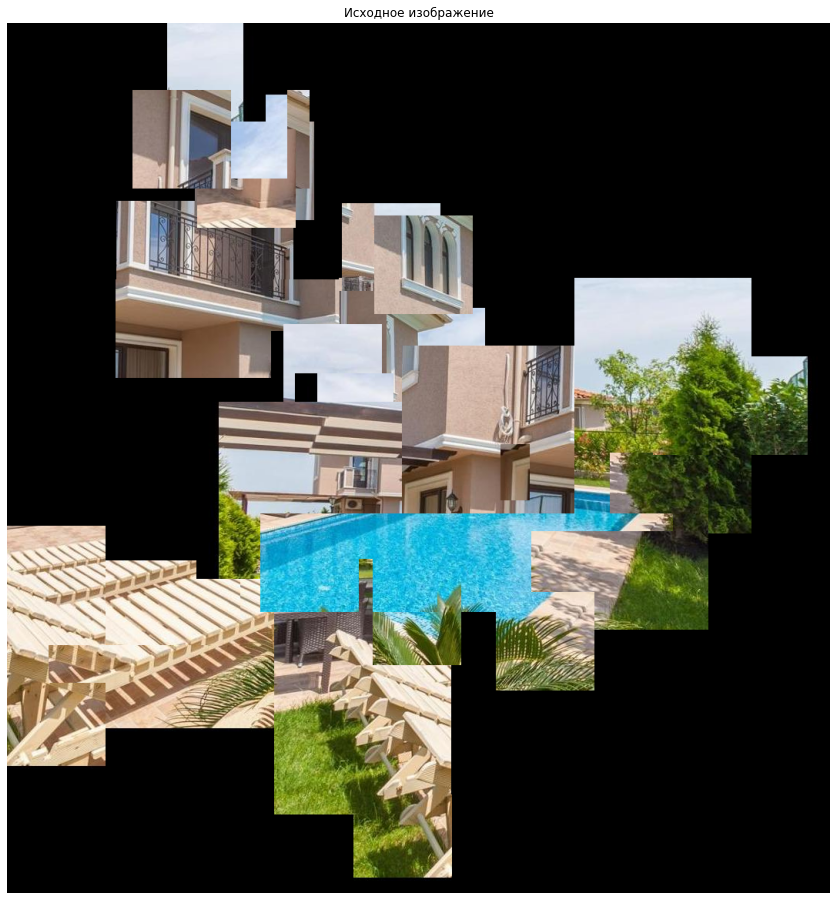

In [599]:
puzzle(pieces)

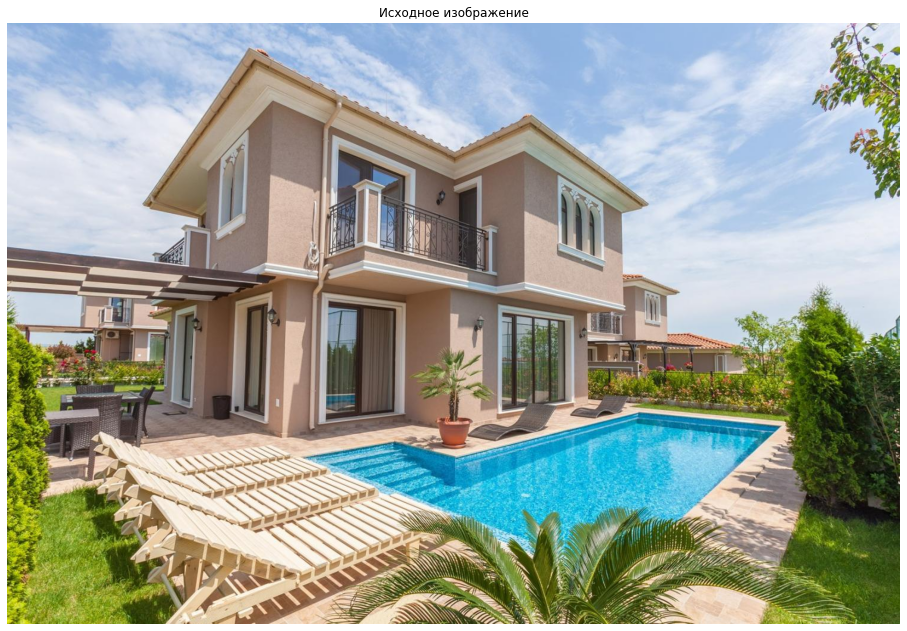

In [600]:
plot_one_image(res_im)

In [429]:
def get_puzzle(name_puzzle):
    path = "./puzzle/"+name_puzzle+'/'
    names = os.listdir(path)
    puzzle = []
    for path_im in os.listdir(path):
        puzzle.append(cv2.imread(path+'/'+path_im))
        puzzle[-1] = cv2.cvtColor(puzzle[-1], cv2.COLOR_BGR2RGB)
    return puzzle

In [15]:
pieces = get_puzzle('su_fighter_shuffle')
res_im = cv2.imread("./puzzle/su_fighter.jpg")
res_im = cv2.cvtColor(res_im, cv2.COLOR_BGR2RGB)

In [62]:
pieces = get_puzzle('china_shuffle')
res_im = cv2.imread("./puzzle/china.jpg")
res_im = cv2.cvtColor(res_im, cv2.COLOR_BGR2RGB)

In [64]:
pieces = get_puzzle('home_shuffle')
res_im = cv2.imread("./puzzle/home.jpg")
res_im = cv2.cvtColor(res_im, cv2.COLOR_BGR2RGB)

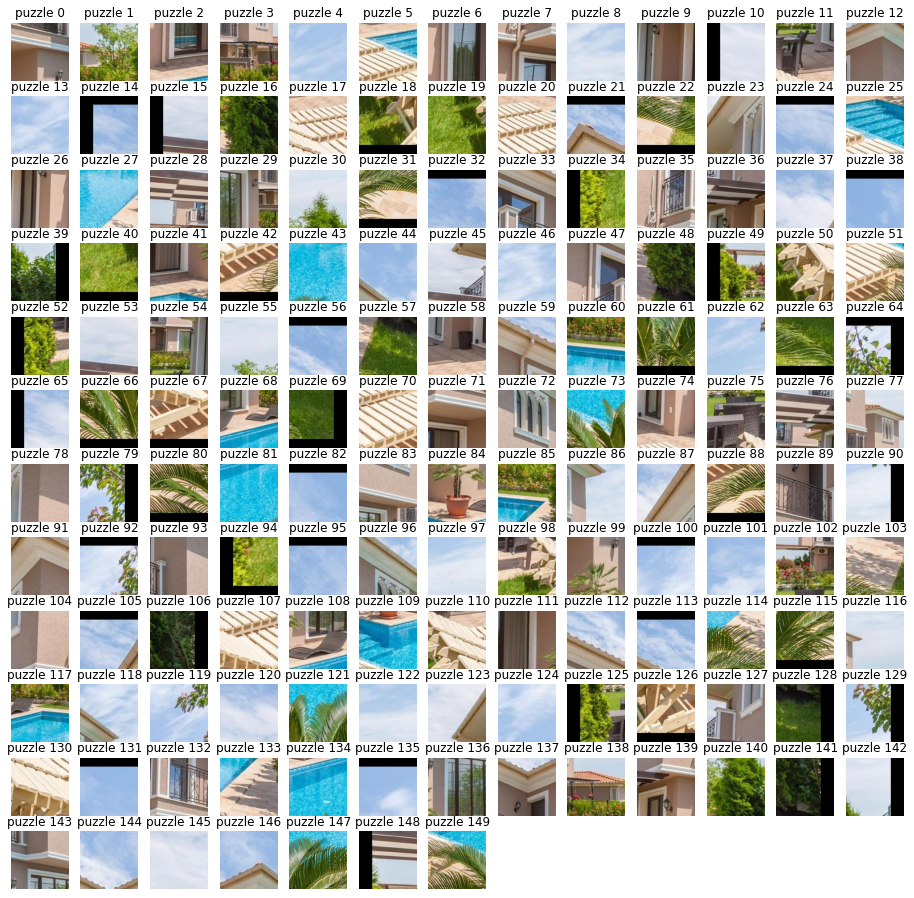

In [449]:
a = int(np.sqrt(len(pieces)))+1
fig, axes = plt.subplots(len(pieces)//a+1, a, figsize=(16, 16))
axes = axes.ravel()

for i in range(len(pieces)):
    axes[i].imshow(pieces[i])
    axes[i].set_title(f'puzzle {i}')
    
for ax in axes:
    ax.axis('off')

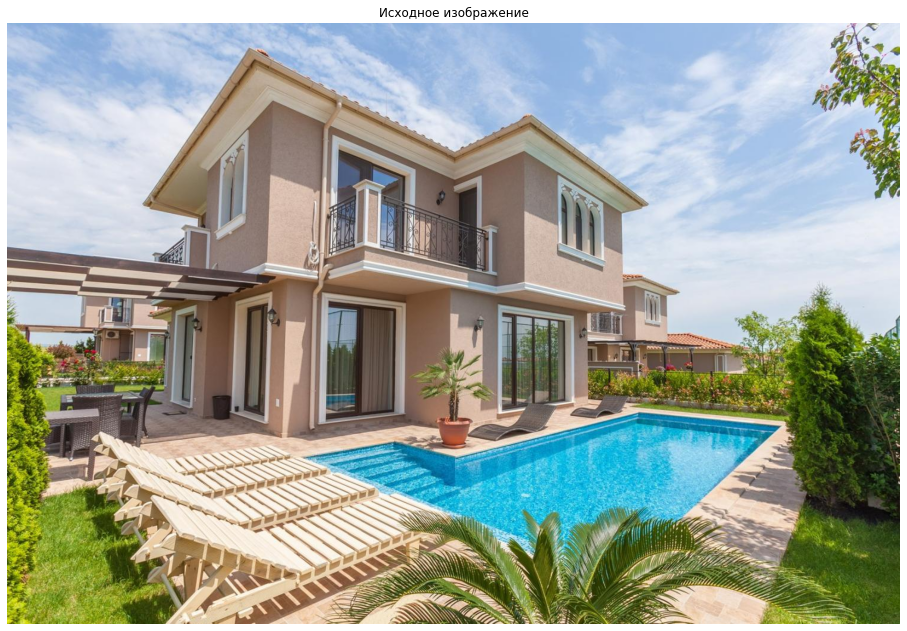

In [450]:
plot_one_image(res_im)

In [451]:
puzzle(pieces)

c:\program files (x86)\python37-32\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice.
c:\program files (x86)\python37-32\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice.


ValueError: attempt to get argmin of an empty sequence